In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt




# Download and preprocess MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


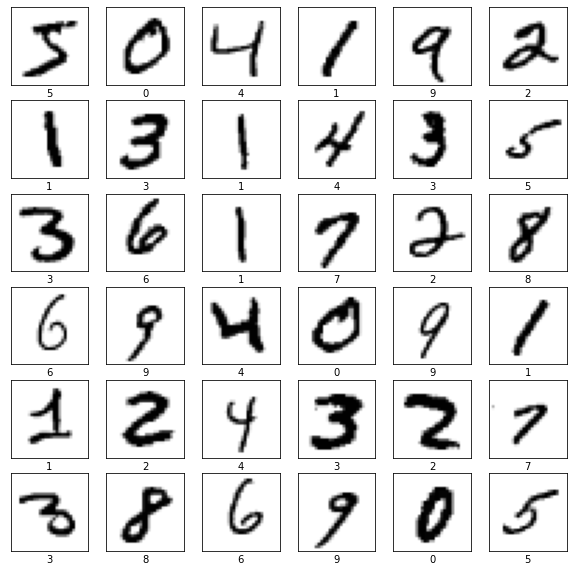

In [3]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [4]:
x_train_rgb = tf.expand_dims(x_train, -1)
x_train_rgb = tf.image.grayscale_to_rgb(x_train_rgb)
x_test_rgb = tf.expand_dims(x_test, -1)
x_test_rgb = tf.image.grayscale_to_rgb(x_test_rgb)
x_train_rgb.shape, x_test_rgb.shape

(TensorShape([60000, 28, 28, 3]), TensorShape([10000, 28, 28, 3]))

In [5]:
x_train_re = tf.image.resize(x_train_rgb, [56, 56])
x_test_re = tf.image.resize(x_test_rgb, [56, 56])

x_train_re.shape, x_test_re.shape

(TensorShape([60000, 56, 56, 3]), TensorShape([10000, 56, 56, 3]))

# Get pretrained CNNs

## Scattering Net

In [6]:
!pip install kymatio
from kymatio.keras import Scattering2D

model_scatter = Scattering2D(J=2, max_order=1)

     |████████████████████████████████| 102kB 4.3MB/s 


## VGG19

In [7]:
model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet', input_shape=(56, 56, 3),
)

model_vgg19.trainable = False
model_vgg19.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
______________________________________________________________

## VGG16

In [8]:
model_vgg16 = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_shape=(56, 56, 3),
)

model_vgg16.trainable = False
model_vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
______________________________________________________________

# Feature extraction and visualization of pretrained CNNs

In [9]:
from time import time
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Feature extraction


In [10]:
def get_full_feature(model, data):
    feature_full = model(data[:1000])
    iter = int(np.round(len(data)/1000-1))
    for i in range(iter):
        feature = model(data[(i+1)*1000:(i+2)*1000])      
        feature_full = tf.concat([feature_full, feature], axis=0)
    return feature_full


In [11]:
feature_scatter_train = get_full_feature(model_scatter, x_train)
feature_scatter_test = get_full_feature(model_scatter, x_test)

feature_scatter_train_re = tf.reshape(feature_scatter_train, [len(feature_scatter_train), -1])
feature_scatter_test_re = tf.reshape(feature_scatter_test, [len(feature_scatter_test), -1])

feature_scatter_train.shape, feature_scatter_test.shape, feature_scatter_train_re.shape, feature_scatter_test_re.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(TensorShape([60000, 17, 7, 7]),
 TensorShape([10000, 17, 7, 7]),
 TensorShape([60000, 833]),
 TensorShape([10000, 833]))

In [12]:
feature_vgg19_train = get_full_feature(model_vgg19, x_train_re)
feature_vgg19_test = get_full_feature(model_vgg19, x_test_re)

feature_vgg19_train_re = tf.reshape(feature_vgg19_train, [60000, -1])
feature_vgg19_test_re = tf.reshape(feature_vgg19_test, [10000, -1])

feature_vgg19_train.shape, feature_vgg19_test.shape, feature_vgg19_train_re.shape, feature_vgg19_test_re.shape

(TensorShape([60000, 1, 1, 512]),
 TensorShape([10000, 1, 1, 512]),
 TensorShape([60000, 512]),
 TensorShape([10000, 512]))

In [13]:
feature_vgg16_train = get_full_feature(model_vgg16, x_train_re)
feature_vgg16_test = get_full_feature(model_vgg16, x_test_re)

feature_vgg16_train_re = tf.reshape(feature_vgg16_train, [60000, -1])
feature_vgg16_test_re = tf.reshape(feature_vgg16_test, [10000, -1])

feature_vgg16_train.shape, feature_vgg16_test.shape, feature_vgg19_train_re.shape, feature_vgg19_test_re.shape

(TensorShape([60000, 1, 1, 512]),
 TensorShape([10000, 1, 1, 512]),
 TensorShape([60000, 512]),
 TensorShape([10000, 512]))

## Visualization

Choose first 5000 features for visualization

In [14]:
feature_scatter = feature_scatter_train_re[:5000]
feature_vgg19 = feature_vgg19_train_re[:5000]
feature_vgg16 = feature_vgg16_train_re[:5000]
label_visual = y_train[:5000]

In [15]:
#reduce dimension
def reduce_dim(method, feature):
    t0 = time()
    result = method.fit_transform(tf.reshape(feature, [len(feature), -1]))
    print('time: %.2f s' %(time() - t0))
    print('shape:', result.shape)
    return result

In [16]:
#draw plot
def get_visualization(result, title):
    fig, ax = plt.subplots()
    scatter = ax.scatter(result[:,0], result[:,1], c=label_visual, s=0.5)
    legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05,1.0))
    ax.grid()
    plt.title(title)
    plt.show()

### t-SNE

In [17]:
tsne = TSNE(n_components=2, init='pca', random_state=0)

In [18]:
tsne_result_scatter = reduce_dim(tsne, feature_scatter)

time: 74.11 s
shape: (5000, 2)


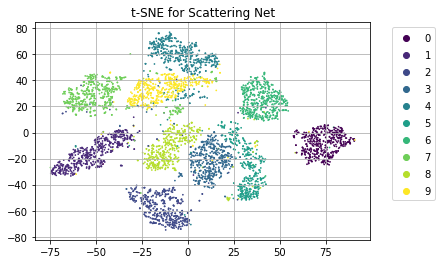

In [ ]:
get_visualization(tsne_result_scatter, 't-SNE for Scattering Net')

In [ ]:
tsne_result_vgg19 = reduce_dim(tsne, feature_vgg19)

time: 55.96 s
shape: (5000, 2)


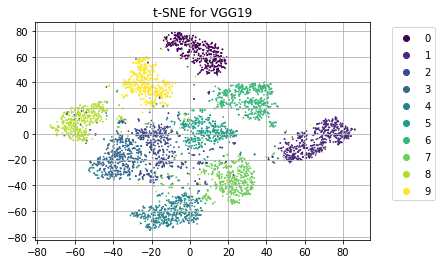

In [ ]:
get_visualization(tsne_result_vgg19, 't-SNE for VGG19')

In [ ]:
tsne_result_vgg16 = reduce_dim(tsne, feature_vgg16)

time: 56.74 s
shape: (5000, 2)


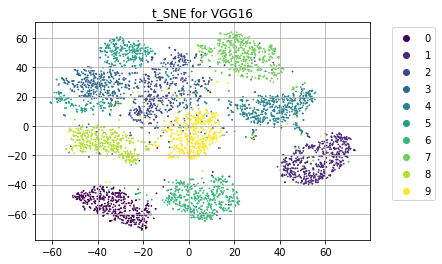

In [ ]:
get_visualization(tsne_result_vgg16, 't_SNE for VGG16')

### PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca_result_scatter = reduce_dim(pca, feature_scatter)

time: 0.23 s
shape: (5000, 2)


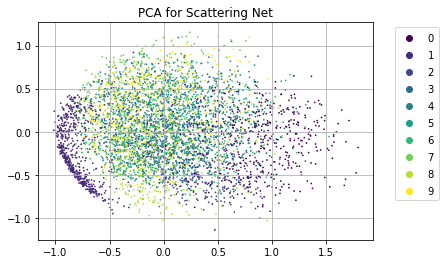

In [ ]:
get_visualization(pca_result_scatter, 'PCA for Scattering Net')

In [ ]:
pca_result_vgg19 = reduce_dim(pca, feature_vgg19)

time: 0.11 s
shape: (5000, 2)


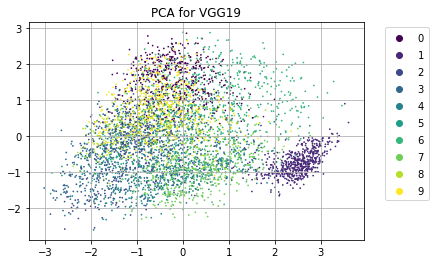

In [ ]:
get_visualization(pca_result_vgg19, 'PCA for VGG19')

In [ ]:
pca_result_vgg16 = reduce_dim(pca, feature_vgg16)

time: 0.11 s
shape: (5000, 2)


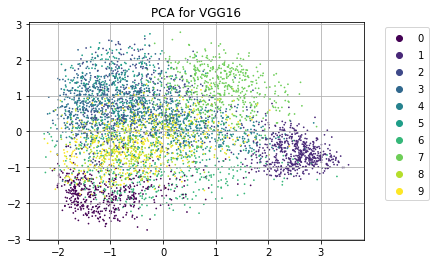

In [ ]:
get_visualization(pca_result_vgg16, 'PCA for VGG16')

# Compute means/covariances

In [ ]:
dict_features = {'scatter': feature_scatter_train_re,
                 'vgg19': feature_vgg19_train_re,
                 'vgg16': feature_vgg16_train_re}

In [ ]:
class feature_properties:
  
    def __init__(self, name):
        self.name = name
        self.feature_full = dict_features[name]
        self.separate_list = self.separate_classes(0)
        self.feature = np.concatenate(self.separate_list)
        self.mu_G = self.get_global_mean()
        self.mu_C = self.get_class_means()


    def separate_classes(self, p):
        lst = []
        for i in range(10):
            lst.append(np.array(self.feature_full)[np.argwhere(y_train==i).flatten()][:5000])   #choose 5000 samples from each class
            if p == 1:
                print(i, lst[i].shape)
        return lst

    def get_global_mean(self):   
        return np.mean(self.feature, axis=0)

    def get_class_means(self):
        lst = []
        for _ in self.separate_list:
            lst.append(np.mean(_, axis=0))
        return lst

    def get_total_cov(self):
        return np.cov(np.transpose(self.feature), bias=True)
    
    def get_between_class_cov(self):
        s = 0
        for mu in self.mu_C:
            s +=np.multiply(np.transpose([mu - self.mu_G]), mu - self.mu_G)
        return s/len(self.mu_C)

    def get_within_class_cov(self):
        s = 0
        for _ in self.separate_list:
            s += np.cov(np.transpose(_), bias=True) * len(_)
        return s/len(self.feature)
        
        
        



Actually, the train global-mean $\mu_G=Ave_{i,c}\{\Phi_{i,c}\}$,

the train class-mean $\mu_C=Ave_{i}\{\Phi_{i,c}\}$,

the train total covariance $\Sigma_T=Ave_{i,c}\{(\Phi_{i,c}-\mu_G)(\Phi_{i,c}-\mu_G)^T\}$,

the between-class covariance $\Sigma_B=Ave_{c}\{(\mu_C-\mu_G)(\mu_C-\mu_G)^T\}$,

the within-class covariance $\Sigma_W=Ave_{i,c}\{(\Phi_{i,c}-\mu_C)(\Phi_{i,c}-\mu_C)^T\}$,

where $\Phi_{i,c}$ are features.

It's easy to prove that for a balanced dataset, having exact $\frac N C$ training examples in each class, it holds $\Sigma_T = \Sigma_B + \Sigma_W$.


## Scattering Net

In [ ]:
scatter_prop = feature_properties('scatter')
separate_list_scatter = scatter_prop.separate_classes(1)

0 (5000, 833)
1 (5000, 833)
2 (5000, 833)
3 (5000, 833)
4 (5000, 833)
5 (5000, 833)
6 (5000, 833)
7 (5000, 833)
8 (5000, 833)
9 (5000, 833)


In [ ]:
print(scatter_prop.feature.shape)

(50000, 833)


In [ ]:
#global mean:
mu_G_scatter = scatter_prop.mu_G

#class means: (list)
mu_C_scatter = scatter_prop.mu_C

#total covaraince matrix:
sigma_T_scatter = scatter_prop.get_total_cov()

#between class covariance:
sigma_B_scatter = scatter_prop.get_between_class_cov()

#within class covariance:
sigma_W_scatter = scatter_prop.get_within_class_cov()

In [ ]:
len(mu_C_scatter)

10

In [ ]:
mu_C_matrix = np.array(mu_C_scatter)
mu_C_matrix.shape

(10, 833)

In [ ]:
#contraction of within class variation
inv_signal_to_noise_ratio_scatter=np.trace(np.dot(sigma_W_scatter, np.linalg.pinv(sigma_B_scatter)))/len(mu_C_scatter)

#closeness to equal-norms of class-means
mu_C_scatter_matrix=np.array(mu_C_scatter)
norm2=np.linalg.norm(mu_C_scatter_matrix-mu_G_scatter, ord=2, axis=1, keepdims=True)
std_c=np.std(norm2)
avg_c=np.mean(norm2)
nc2_1_scatter=std_c/avg_c


cos_scatter=np.zeros((len(mu_C_scatter),len(mu_C_scatter)))
for i in range (len(mu_C_scatter)):
  for j in range (len(mu_C_scatter)):
    cos_scatter[i][j]=np.dot(mu_C_scatter[i]-mu_G_scatter,mu_C_scatter[j]-mu_G_scatter)/(np.linalg.norm(mu_C_scatter[i]-mu_G_scatter,ord=2)*np.linalg.norm(mu_C_scatter[j]-mu_G_scatter,ord=2))

cos_scatter_diag = np.diag(cos_scatter)
cos_scatter_offdiag = cos_scatter[~np.eye(cos_scatter.shape[0],dtype=bool)].reshape(cos_scatter.shape[0],-1) #c*(c-1) matrix
#equal-angularity
nc2_2_scatter_diag=np.std(cos_scatter_diag)
nc2_2_scatter_offdiag=np.std(cos_scatter_offdiag)
#closeness to maximal-angle equiangularity
nc2_3_scatter_diag=np.mean(cos_scatter_diag)+1/(len(mu_C_scatter)-1)
nc2_3_scatter_offdiag=np.mean(cos_scatter_offdiag)+1/(len(mu_C_scatter)-1)

print(inv_signal_to_noise_ratio_scatter)
print(nc2_1_scatter)
print(nc2_2_scatter_diag)
print(nc2_2_scatter_offdiag)
print(nc2_3_scatter_diag)
print(nc2_2_scatter_offdiag)

8489157.112578422
0.23728772
8.513246093443453e-08
0.2636028035192016
1.111111134952969
0.2636028035192016


For ScatNet, VGG19, VGG16, the standard deviations of the off-diagonal elements of the cos matrix are all small ($10^{-8}$) (equal-angularity). 

The last two lines provide evidence for the proposition:
$<\tilde{\mu_c},\tilde{\mu_{c'}}>\to \frac{C}{C-1}\delta_{c,c'}-\frac{1}{C-1}$. Actually, when $c\neq c'$, the value is quite close to $\frac{C}{C-1}=\frac {10}9$.

Some values are not so close to the expected ones. This phenomenon is probably because that the Neural Collapse paper uses features trained beyond zero-error (TPT), but our experiments' training errors are still larger than 0, thus leading to unsatisfied results.

##VGG19

In [ ]:
vgg19_prop = feature_properties('vgg19')
separate_list_vgg19 = vgg19_prop.separate_classes(1)

0 (5000, 512)
1 (5000, 512)
2 (5000, 512)
3 (5000, 512)
4 (5000, 512)
5 (5000, 512)
6 (5000, 512)
7 (5000, 512)
8 (5000, 512)
9 (5000, 512)


In [ ]:
#global mean:
mu_G_vgg19 = vgg19_prop.mu_G

#class means: (list)
mu_C_vgg19 = vgg19_prop.mu_C

#total covaraince matrix:
sigma_T_vgg19 = vgg19_prop.get_total_cov()

#between class covariance:
sigma_B_vgg19 = vgg19_prop.get_between_class_cov()

#within class covariance:
sigma_W_vgg19 = vgg19_prop.get_within_class_cov()

In [ ]:
#contraction of within class variation
inv_signal_to_noise_ratio_vgg19=np.trace(np.dot(sigma_W_vgg19, np.linalg.pinv(sigma_B_vgg19)))/len(mu_C_vgg19)

#closeness to equal-norms of class-means
mu_C_vgg19_matrix=np.array(mu_C_vgg19)
norm2=np.linalg.norm(mu_C_vgg19_matrix-mu_G_vgg19, ord=2, axis=1, keepdims=True)
std_c=np.std(norm2)
avg_c=np.mean(norm2)
nc2_1_vgg19=std_c/avg_c


cos_vgg19=np.zeros((len(mu_C_vgg19),len(mu_C_vgg19)))
for i in range (len(mu_C_vgg19)):
  for j in range (len(mu_C_vgg19)):
    cos_vgg19[i][j]=np.dot(mu_C_vgg19[i]-mu_G_vgg19,mu_C_vgg19[j]-mu_G_vgg19)/(np.linalg.norm(mu_C_vgg19[i]-mu_G_vgg19,ord=2)*np.linalg.norm(mu_C_vgg19[j]-mu_G_vgg19,ord=2))

cos_vgg19_diag = np.diag(cos_vgg19)
cos_vgg19_offdiag = cos_vgg19[~np.eye(cos_vgg19.shape[0],dtype=bool)].reshape(cos_vgg19.shape[0],-1)
#equal-angularity
nc2_2_vgg19_diag=np.std(cos_vgg19_diag)
nc2_2_vgg19_offdiag=np.std(cos_vgg19_offdiag)
#closeness to maximal-angle equiangularity
nc2_3_vgg19_diag=np.mean(cos_vgg19_diag)+1/(len(mu_C_vgg19)-1)
nc2_3_vgg19_offdiag=np.mean(cos_vgg19_offdiag)+1/(len(mu_C_vgg19)-1)

print(inv_signal_to_noise_ratio_vgg19)
print(nc2_1_vgg19)
print(nc2_2_vgg19_diag)
print(nc2_2_vgg19_offdiag)
print(nc2_3_vgg19_diag)
print(nc2_3_vgg19_offdiag)

-317460509.92699325
0.2358915
5.623090941939714e-08
0.2774348903408837
1.1111111051506466
0.00980964017411072


## VGG16

In [ ]:
vgg16_prop = feature_properties('vgg16')
separate_list_vgg16 = vgg16_prop.separate_classes(1)

0 (5000, 512)
1 (5000, 512)
2 (5000, 512)
3 (5000, 512)
4 (5000, 512)
5 (5000, 512)
6 (5000, 512)
7 (5000, 512)
8 (5000, 512)
9 (5000, 512)


In [ ]:
#global mean:
mu_G_vgg16 = vgg16_prop.mu_G

#class means: (list)
mu_C_vgg16 = vgg16_prop.mu_C

#total covaraince matrix:
sigma_T_vgg16 = vgg16_prop.get_total_cov()

#between class covariance:
sigma_B_vgg16 = vgg16_prop.get_between_class_cov()

#within class covariance:
sigma_W_vgg16 = vgg16_prop.get_within_class_cov()

In [ ]:
#contraction of within class variation
inv_signal_to_noise_ratio_vgg16=np.trace(np.dot(sigma_W_vgg16, np.linalg.pinv(sigma_B_vgg16)))/len(mu_C_vgg16)

#closeness to equal-norms of class-means
mu_C_vgg16_matrix=np.array(mu_C_vgg16)
norm2=np.linalg.norm(mu_C_vgg16_matrix-mu_G_vgg16, ord=2, axis=1, keepdims=True)
std_c=np.std(norm2)
avg_c=np.mean(norm2)
nc2_1_vgg16=std_c/avg_c


cos_vgg16=np.zeros((len(mu_C_vgg16),len(mu_C_vgg16)))
for i in range (len(mu_C_vgg16)):
  for j in range (len(mu_C_vgg16)):
    cos_vgg16[i][j]=np.dot(mu_C_vgg16[i]-mu_G_vgg16,mu_C_vgg16[j]-mu_G_vgg16)/(np.linalg.norm(mu_C_vgg16[i]-mu_G_vgg16,ord=2)*np.linalg.norm(mu_C_vgg16[j]-mu_G_vgg16,ord=2))

cos_vgg16_diag = np.diag(cos_vgg16)
cos_vgg16_offdiag = cos_vgg16[~np.eye(cos_vgg16.shape[0],dtype=bool)].reshape(cos_vgg16.shape[0],-1)
#equal-angularity
nc2_2_vgg16_diag=np.std(cos_vgg16_diag)
nc2_2_vgg16_offdiag=np.std(cos_vgg16_offdiag)
#closeness to maximal-angle equiangularity
nc2_3_vgg16_diag=np.mean(cos_vgg16_diag)+1/(len(mu_C_vgg16)-1)
nc2_3_vgg16_offdiag=np.mean(cos_vgg16_offdiag)+1/(len(mu_C_vgg16)-1)

print(inv_signal_to_noise_ratio_vgg16)
print(nc2_1_vgg16)
print(nc2_2_vgg16_diag)
print(nc2_2_vgg16_offdiag)
print(nc2_3_vgg16_diag)
print(nc2_3_vgg16_offdiag)

-427514635.84189063
0.28987598
7.748603820800782e-08
0.2882076304639147
1.1111111051506466
0.013969382105602154


# Image classifications using traditional supervised learning methods based on the features extracted

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.tree import DecisionTreeClassifier

## SVM

In [ ]:
clf_svc_scatter = SVC()
clf_svc_scatter.fit(feature_scatter_train_re, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf_svc_vgg19 = SVC()
clf_svc_vgg19.fit(feature_vgg19_train_re, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf_svc_vgg16 = SVC()
clf_svc_vgg16.fit(feature_vgg16_train_re, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Scores are printed below:**

In [ ]:
score_svc_scatter = clf_svc_scatter.score(feature_scatter_test_re, y_test)
print('The score of SVM based on Scattering Net is : %f' %score_svc_scatter)

The score of SVM based on Scattering Net is : 0.990700


In [ ]:
score_svc_vgg19 = clf_svc_vgg19.score(feature_vgg19_test_re, y_test)
print('The score of SVM based on VGG19 is : %f' %score_svc_vgg19)

The score of SVM based on VGG19 is : 0.971200


In [ ]:
score_svc_vgg16 = clf_svc_vgg16.score(feature_vgg16_test_re, y_test)
print('The score of SVM based on VGG16 is : %f' %score_svc_vgg16)

The score of SVM based on VGG16 is : 0.972100


## Logistic Regression

In [ ]:
clf_lr_scatter = LogisticRegression()
clf_lr_scatter.fit(feature_scatter_train_re, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
clf_lr_vgg19 = LogisticRegression()
clf_lr_vgg19.fit(feature_vgg19_train_re, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
clf_lr_vgg16 = LogisticRegression()
clf_lr_vgg16.fit(feature_vgg16_train_re, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Scores are printed below:**

In [ ]:
score_lr_scatter = clf_lr_scatter.score(feature_scatter_test_re, y_test)
print('The score of Logistic Regression based on Scattering Net is: %f' %score_lr_scatter)

The score of Logistic Regression based on Scattering Net is: 0.982400


In [ ]:
score_lr_vgg19 = clf_lr_vgg19.score(feature_vgg19_test_re, y_test)
print('The score of Logistic Regression based on VGG19 is: %f' %score_lr_vgg19)

The score of Logistic Regression based on VGG19 is: 0.969900


In [ ]:
score_lr_vgg16 = clf_lr_vgg16.score(feature_vgg16_test_re, y_test)
print('The score of Logistic Regression based on VGG16 is: %f' %score_lr_vgg16)

The score of Logistic Regression based on VGG16 is: 0.967600


## Random Forest

In [ ]:
clf_rf_scatter = RandomForestClassifier(n_estimators=10)
clf_rf_scatter.fit(feature_scatter_train_re, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf_rf_vgg19 = RandomForestClassifier(n_estimators=10)
clf_rf_vgg19.fit(feature_vgg19_train_re, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf_rf_vgg16 = RandomForestClassifier(n_estimators=10)
clf_rf_vgg16.fit(feature_vgg16_train_re, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Scores are printed below:**

In [ ]:
score_rf_scatter = clf_rf_scatter.score(np.array(feature_scatter_test_re), y_test)
print('The score of Random Forest based on Scattering Net is : %f' %score_rf_scatter)

The score of Random Forest based on Scattering Net is : 0.969600


In [ ]:
score_rf_vgg19 = clf_rf_vgg19.score(np.array(feature_vgg19_test_re), y_test)
print('The score of Random Forest based on VGG19 is: %f' %score_rf_vgg19)

The score of Random Forest based on VGG19 is: 0.938600


In [ ]:
score_rf_vgg16 = clf_rf_vgg16.score(np.array(feature_vgg16_test_re), y_test)
print('The score of Random Forest based on VGG16 is: %f' %score_rf_vgg16)

The score of Random Forest based on VGG16 is: 0.924900


## LDA

In [ ]:
#clf_lda_vgg19 = LatentDirichletAllocation(n_components=10, max_iter=10)
#clf_lda_vgg19.fit(feature_vgg19_train_re, y_train)

In [ ]:
#score_lda_vgg19 = clf_lda_vgg19.score(np.array(feature_vgg19_test_re), y_test)
#print('The score of LDA based on VGG19 is: %f' %score_lda_vgg19)

## Decision Tree

In [ ]:
clf_dc_scatter = DecisionTreeClassifier()
clf_dc_scatter.fit(feature_scatter_train_re, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
clf_dc_vgg19 = DecisionTreeClassifier()
clf_dc_vgg19.fit(feature_vgg19_train_re, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
clf_dc_vgg16 = DecisionTreeClassifier()
clf_dc_vgg16.fit(feature_vgg16_train_re, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

**Scores are printed below:**

In [ ]:
score_dc_scatter = clf_dc_scatter.score(np.array(feature_scatter_test_re), y_test)
print('The score of Decision Tree based on Scattering Net is : %f' %score_dc_scatter)

The score of Decision Tree based on Scattering Net is : 0.916500


In [ ]:
score_dc_vgg19 = clf_dc_vgg19.score(np.array(feature_vgg19_test_re), y_test)
print('The score of Decision Tree based on VGG19 is : %f' %score_dc_vgg19)

The score of Decision Tree based on VGG19 is : 0.872400


In [ ]:
score_dc_vgg16 = clf_dc_vgg16.score(np.array(feature_vgg16_test_re), y_test)
print('The score of Decision Tree based on VGG16 is : %f' %score_dc_vgg16)

The score of Decision Tree based on VGG16 is : 0.860600


## plots

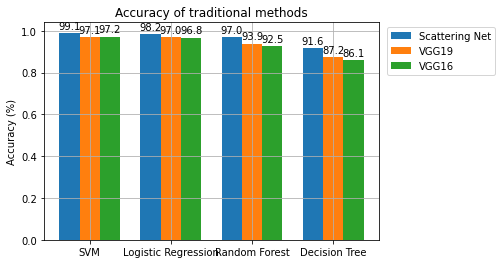

In [ ]:
clf_labels = ['SVM', 'Logistic Regression', 'Random Forest', 'Decision Tree']
clf_vgg19 = [score_svc_vgg19, score_lr_vgg19, score_rf_vgg19, score_dc_vgg19]
clf_vgg16 = [score_svc_vgg16, score_lr_vgg16, score_rf_vgg16, score_dc_vgg16]
clf_scatter = [score_svc_scatter, score_lr_scatter, score_rf_scatter, score_dc_scatter]


def get_clf_plots():
    x = np.arange(len(clf_labels)) *1.2
    width = 0.6
    fig, ax = plt.subplots()
    rects_scatter = ax.bar(x - width/2, clf_scatter, width/2, label='Scattering Net')
    rects_vgg19 = ax.bar(x, clf_vgg19, width/2, label='VGG19')
    rects_vgg16 = ax.bar(x + width/2, clf_vgg16, width/2, label='VGG16')
    ax.set_title('Accuracy of traditional methods')
    ax.set_ylabel('Accuracy (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(clf_labels)
    ax.legend(bbox_to_anchor=(1.01, 1.0))
    ax.grid()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(100 * height, 1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    autolabel(rects_scatter)
    autolabel(rects_vgg19)
    autolabel(rects_vgg16)

    plt.show()

get_clf_plots()